# LSTM Baseline Model Testing

## 0 Imports & Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from utils import load_complete_time_series, split_data_into_sequences, reconstruct_sequential_data
from LSTM import LSTM, train_model, scale_data, train_test_split_to_tensor, inverse_scale_data
from TimeSeriesDataset import TimeSeriesDataset
from mean_regressor import MeanRegressor

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = True

### Hyperparameters

In [5]:
SEQ_LEN = 14
LEARNING_RATE = 0.001
BATCH_SIZE = 32
HIDDEN_SIZE = 12
NUM_LAYERS = 1

NUM_EPOCHS = 1000

### Features

In [6]:
FEATURES = ['Close', 'Volume']
NUM_FEATURES_PER_TIME_STEP = len(FEATURES)
FEATURES_INCL_DATE = FEATURES + ['Date']

## 2 Data

### Data Loading

In [15]:
# Load data from csv
# -> convert Date column to datetime
data = load_complete_time_series(f'{REAL_DATA_FOLDER}/AAPL_10_24_real.csv')
data = data[FEATURES_INCL_DATE] # remember to put the target column first
data[SEQ_LEN-1:SEQ_LEN+10]

,Close,Volume,Date
14,7.252500,1065699600,2010-01-25
15,7.355000,1867110000,2010-01-26
16,7.424286,1722568400,2010-01-27
17,7.117500,1173502400,2010-01-28
18,6.859286,1245952400,2010-01-29
19,6.954643,749876400,2010-02-01
20,6.995000,698342400,2010-02-02
21,7.115357,615328000,2010-02-03
22,6.858929,757652000,2010-02-04
23,6.980714,850306800,2010-02-05


### Data Preprocessing

In [12]:
data_split = split_data_into_sequences(data, SEQ_LEN)

Shape of the data after splitting into sequences: (3604, 14, 2)


In [13]:
data_origin = reconstruct_sequential_data(data_split)

In [9]:
_, _, X_test_unscaled, y_test_unscaled = train_test_split_to_tensor(data_split) # save unscaled data for dummy regressor

Shape of X_train: torch.Size([3423, 13, 2]) 
 Shape of y_train: torch.Size([3423, 1]) 
 Shape of X_test: torch.Size([181, 13, 2]) 
 Shape of y_test: torch.Size([181, 1])


In [10]:
data_split, scaler_close = scale_data(data_split)

In [11]:
X_train, y_train, X_test, y_test = train_test_split_to_tensor(data_split)


Shape of X_train: torch.Size([3423, 13, 2]) 
 Shape of y_train: torch.Size([3423, 1]) 
 Shape of X_test: torch.Size([181, 13, 2]) 
 Shape of y_test: torch.Size([181, 1])


In [12]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# Visualize size of batches
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 13, 2]) torch.Size([32, 1])


## 3 Train Test Loop

In [15]:
# parameters for ['Close']: input_size=1, hidden_size=4, num_stacked_layers=1
model = LSTM(
    device=device,
    input_size=NUM_FEATURES_PER_TIME_STEP,
    hidden_size=HIDDEN_SIZE,
    num_stacked_layers=NUM_LAYERS
).to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.7, patience=15, threshold=0.001)
criterion = nn.MSELoss()
criterion_absolute = nn.L1Loss()

In [17]:
best_validation_loss, model = train_model(model=model,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device)

Epoch: 1
Validation Loss: 0.010439399474610886
**************************************************
Epoch: 2
Validation Loss: 0.002274378120394734
**************************************************
Epoch: 3
Validation Loss: 0.002392250346019864
INFO: Validation loss did not improve in epoch 3
**************************************************
Epoch: 4
Validation Loss: 0.002273075510553705
**************************************************
Epoch: 5
Validation Loss: 0.0016752485632120322
**************************************************
Epoch: 6
Validation Loss: 0.0013725270206729572
**************************************************
Epoch: 7
Validation Loss: 0.0017865348927443847
INFO: Validation loss did not improve in epoch 7
**************************************************
Epoch: 8
Validation Loss: 0.0013629930569247033
**************************************************
Epoch: 9
Validation Loss: 0.0013048290275037289
**************************************************
Epoch: 10
Valid

## 4 Plot Predictions

### Inverse Transform

In [18]:
with torch.inference_mode(): 
    test_pred = model(X_test.to(device)).to('cpu').detach().numpy()
    train_pred = model(X_train.to(device)).to('cpu').detach().numpy()

In [19]:
test_pred = inverse_scale_data(test_pred, scaler_close, SEQ_LEN)
train_pred = inverse_scale_data(train_pred, scaler_close, SEQ_LEN)
y_test = inverse_scale_data(y_test, scaler_close, SEQ_LEN)
y_train = inverse_scale_data(y_train, scaler_close, SEQ_LEN)

Shape of the inverse scaled numpy array: (181,)
Shape of the inverse scaled numpy array: (3423,)
Shape of the inverse scaled numpy array: (181,)
Shape of the inverse scaled numpy array: (3423,)


In [20]:
loss = criterion_absolute(torch.tensor(test_pred), torch.tensor(y_test)).item()
loss

1.8097941004639932

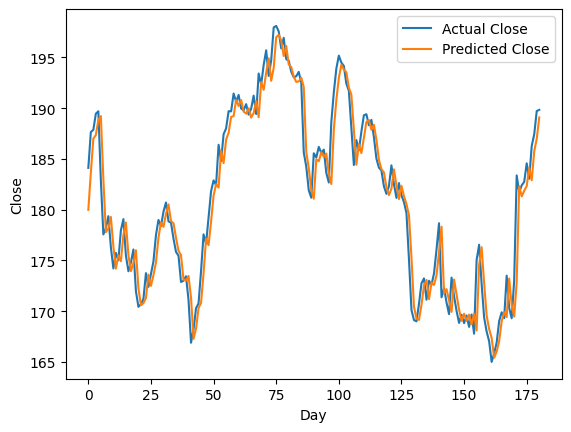

In [21]:
# plot test data
plt.plot(y_test, label="Actual Close")
plt.plot(test_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


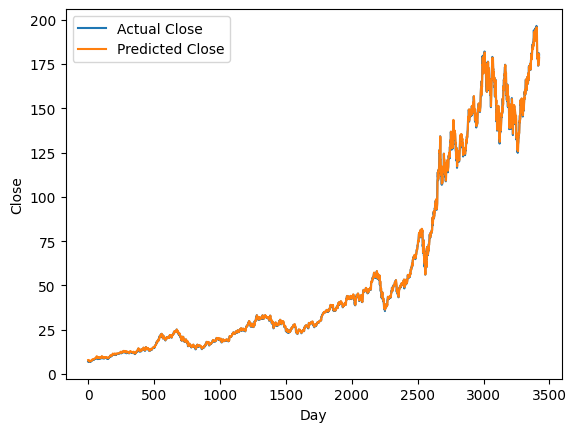

In [22]:
# plot train data
plt.plot(y_train, label="Actual Close")
plt.plot(train_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


### Dummy Testing

In [23]:
dummy_model = MeanRegressor()
dummy_pred = dummy_model.make_predictions(X_test_unscaled)

In [24]:
dummy_pred.shape

(181,)

In [25]:
loss = criterion_absolute(torch.tensor(dummy_pred), y_test_unscaled).item()
loss

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([181, 1])) that is different to the input size (torch.Size([181])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


10.306831696095474

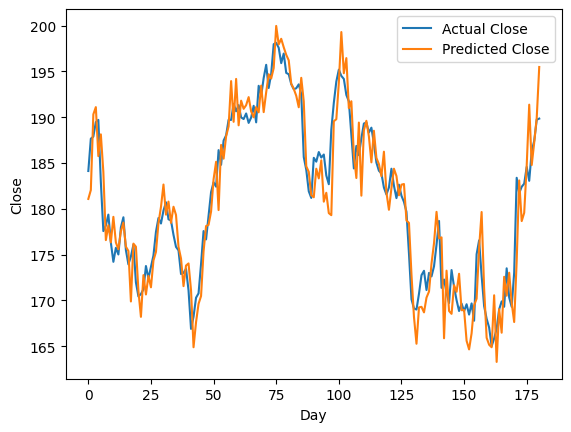

In [26]:
# plot test data
plt.plot(y_test, label="Actual Close")
plt.plot(dummy_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()